<a href="https://colab.research.google.com/github/lmassaron/ml4dummies_3ed/blob/main/ML4D3E_16_classifying_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
import keras
from keras import layers, optimizers, losses, metrics
#from keras.utils import to_categorical
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [ ]:
ds = load_dataset("lmassaron/dogs-cats-openimages")

In [ ]:
print(f"Train dataset size: {len(ds['train'])}")
print(f"Test dataset size: {len(ds['validation'])}")
print(f"Test dataset size: {len(ds['test'])}")

Train dataset size: 3360
Test dataset size: 720
Test dataset size: 720


In [ ]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32
EPOCHS = 25

In [ ]:
def process_images(data):
  all_images_list = []
  all_labels_list = []

  for example in tqdm(data):
    pil_image = example['image']
    label = example['label']
    img_rgb = pil_image.convert("RGB")
    img_resized = img_rgb.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.utils.img_to_array(img_resized, dtype='float32')

    all_images_list.append(img_array)
    all_labels_list.append(label)

  x_np = np.array(all_images_list)
  y_np = np.array(all_labels_list)
  return x_np, y_np

x_train, y_train = process_images(ds['train'])
x_valid, y_valid = process_images(ds['validation'])
x_test, y_test = process_images(ds['test'])

100%|██████████| 720/720 [00:03<00:00, 196.91it/s]


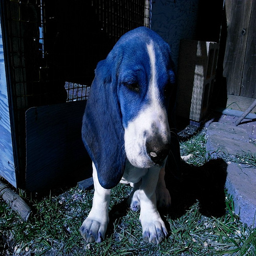

0


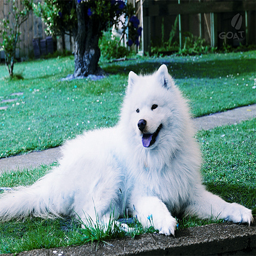

0


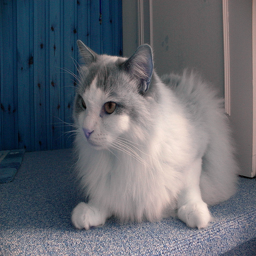

1


In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(x_train[0])
print(y_train[0])
cv2_imshow(x_valid[0])
print(y_valid[0])
cv2_imshow(x_test[0])
print(y_test[0])

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=(-0.05, 0.05) )
    ],
    name="data_augmentation")

In [ ]:
keras.utils.set_random_seed(0)

def conv_block(filters, kernel_size, name):
  params = {
      "filters": filters,
      "kernel_size": kernel_size,
      "activation": "relu",
      "padding": "same"}
  block = [
      layers.Conv2D(**params),
      layers.Conv2D(**params),
      layers.MaxPooling2D((2, 2))
  ]
  return keras.Sequential(block, name=name)

model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        layers.Rescaling(1.0 / 255),
        data_augmentation,

        conv_block(32, 5, name="conv_block1"),
        layers.BatchNormalization(),
        conv_block(32, 4, name="conv_block2"),
        conv_block(64, 4, name="conv_block3"),
        layers.BatchNormalization(),
        conv_block(64, 3, name="conv_block4"),
        conv_block(128, 3, name="conv_block5"),
        layers.BatchNormalization(),
        conv_block(128, 2, name="conv_block6"),
        conv_block(256, 2, name="conv_block7"),
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="simple_cat_dog_classifier")

In [ ]:
model.summary()

Model: "simple_cat_dog_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block1 (Sequential)        │ (None, 128, 128, 32)   │        28,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block2 (Sequential)        │ (None, 64, 64, 32)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block3 (Sequential)        │ (None, 32, 32, 64)     │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block4 (Sequential)        │ (None, 16, 16, 64)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block5 (Sequential)        │ (None, 8, 8, 128)      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block6 (Sequential)        │ (None, 4, 4, 128)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block7 (Sequential)        │ (None, 2, 2, 256)      │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,022,817 (3.90 MB)

 Trainable params: 1,021,857 (3.90 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
model.compile(
    optimizer=optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_valid, y_valid),
    shuffle=True,
    callbacks=[early_stopping])

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 101s 615ms/step - accuracy: 0.5711 - loss: 0.7137 - val_accuracy: 0.5000 - val_loss: 0.7185
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.6015 - loss: 0.6654 - val_accuracy: 0.6069 - val_loss: 0.6665
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 568ms/step - accuracy: 0.6190 - loss: 0.6593 - val_accuracy: 0.6375 - val_loss: 0.6794
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 571ms/step - accuracy: 0.6591 - loss: 0.6161 - val_accuracy: 0.5083 - val_loss: 0.9237
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 572ms/step - accuracy: 0.6780 - loss: 0.6021 - val_accuracy: 0.6958 - val_loss: 0.5985
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 568ms/step - accuracy: 0.6836 - loss: 0.5908 - val_accuracy: 0.5417 - val_loss: 0.8355
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 60s 567ms/step - accuracy: 0.7295 - loss: 0.5534 - val_accuracy: 0.5944 - val_loss: 0.8074
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 59s 564ms/step - accuracy: 0.7372 - loss: 

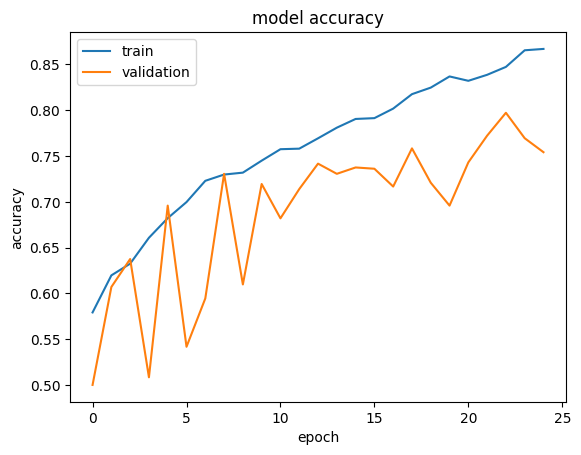

In [ ]:
def plot_history(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"],
               loc="upper left")
    plt.show()

plot_history(history)

In [ ]:
loss_value, accuracy_value = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f"test accuracy {accuracy_value:0.3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8004 - loss: 0.4380
test accuracy 0.817


In [ ]:
keras.utils.set_random_seed(0)

transfer_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

transfer_model.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        data_augmentation,
        transfer_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ], name="EffNetV2_cat_dog_classifier")

In [ ]:
model.compile(
    optimizer=optimizers.Adam(),
    loss = "binary_crossentropy",
    metrics = ["accuracy"],
)

In [ ]:
model.summary()

Model: "EffNetV2_cat_dog_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 8, 8, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,925,713 (22.60 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=1,
    validation_data=(x_valid, y_valid),
    shuffle=True,
)

105/105 ━━━━━━━━━━━━━━━━━━━━ 104s 839ms/step - accuracy: 0.8762 - loss: 0.2758 - val_accuracy: 0.9917 - val_loss: 0.1065


In [ ]:
loss_value, accuracy_value = model.evaluate(
    x_test,
    y_test,
    batch_size=BATCH_SIZE)
print(f"test accuracy {accuracy_value:0.3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.9983 - loss: 0.0929
test accuracy 0.997
